<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S5/Stanford_Sentiment_Treebank_Classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - using LSTM
Dataset : **Stanford Sentiment Treebank**

Steps covered in this notebook:
1. Knowing the data



# Setting Up

In [1]:
! pip install pytreebank

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=20486e4e06a4623184c550b8097ecb9f7e838881f4b755b95ce92dce7b226d1a
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank


In [2]:
! git clone https://github.com/namanphy/END2.git

Cloning into 'END2'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 201 (delta 83), reused 151 (delta 51), pack-reused 0
Receiving objects: 100% (201/201), 6.81 MiB | 7.19 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [3]:
cd /content/END2/S5

/content/END2/S5


In [4]:
! unzip /content/END2/S5/stanfordSentimentTreebank.zip 

unzip:  cannot find or open /content/END2/S5/stanfordSentimentTreebank.zip, /content/END2/S5/stanfordSentimentTreebank.zip.zip or /content/END2/S5/stanfordSentimentTreebank.zip.ZIP.


In [5]:
ls

data/  exp/  model/  trainer/  utils.py


In [6]:
import os
import torch, torchtext
from torchtext.legacy import data 
import pandas as pd

from data import sentences_to_dataframe
from model import LSTM, BiLSTM, count_parameters
from trainer.loss import cross_entropy_loss
from trainer.optimizer import adam_optimizer
from trainer.train import train
from utils import binary_accuracy, plot_metric

# Manual Seed
SEED = 45
torch.manual_seed(SEED)



---



# Preparing the data

SST consists of 11,855 sentences extracted from movie reviews with fine-grained sentiment labels [1–5], as well as 215,154 phrases that compose each sentence in the dataset.


## Generating train and test sentence-label dataframes
From raw txt files..

In [7]:
df_train, df_test = sentences_to_dataframe(path_sst='/content/END2/S5/data/stanfordSentimentTreebank', seed=SEED)

Adding 940 more rows to trainset.


/content/END2/S5/data/sst_dataset.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(out_path.format('train'), sep='\t\t', header=None, names=['label', 'text'])
/content/END2/S5/data/sst_dataset.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  for f in ['test', 'dev']), ignore_index=True)


In [8]:
print(df_train.shape)
print(df_test.shape)
df_train.head(2)

(9484, 2)
(2371, 3)


,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...


## Adding Augmented files to training data

In [124]:
df_delete = pd.read_csv('random_delete_25percent.csv')
df_swap = pd.read_csv('random_swap_25percent.csv')
df_translate = pd.read_csv('back_translate_5percent.csv')

In [129]:
df_train = pd.concat((df_train, df_delete, df_swap, df_translate), ignore_index=True)

In [130]:
# Final Shapes

print('Final Shapes of : ')
print('\tTrain set - ', df_train.shape)
print('\tTest set  - ', df_test.shape)
df_train.head(2)

Final Shapes of : 
	Train set -  (14700, 2)
	Test set  -  (2371, 3)


,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...


## Knowing our Data

Our dataset is ofcourse not balanced. It is clear that most of the training samples belong to classes 2 and 4. Also a good number of samples belong to `neutral` class i.e. label 3.


Text(0, 0.5, 'Number of Samples in training Set')

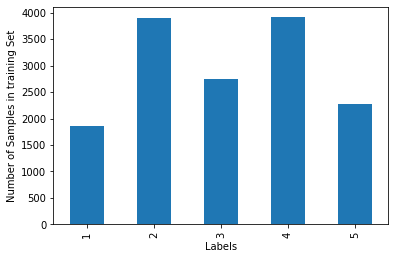

In [131]:
import matplotlib.pyplot as plt

ax = df_train['label'].value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Labels")
ax.set_ylabel("Number of Samples in training Set")

What's the distribution of the lengths of the data ?

**It has a average of 102 in the training set.**

count    14700.000000
mean        94.199320
std         53.310125
min          1.000000
25%         53.000000
50%         90.000000
75%        130.000000
max        267.000000
dtype: float64

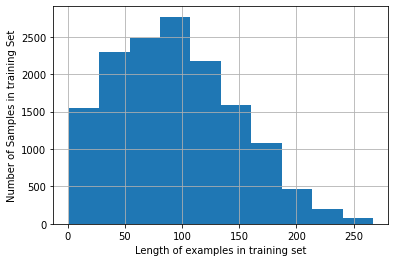

In [132]:
reviews_len = [len(x) for x in df_train['text']]
ax = pd.Series(reviews_len).hist()
ax.set_xlabel("Length of examples in training set")
ax.set_ylabel("Number of Samples in training Set")
pd.Series(reviews_len).describe()

In [133]:
min(reviews_len)

1

## Making a torchtext dataset and dataloader

In [134]:
text = data.Field(sequential=True, tokenize='spacy', batch_first =True, include_lengths=True)
label = data.LabelField(sequential=False, tokenize ='spacy',  batch_first=True, is_target=True)

In [135]:
fields = [('texts', text), ('labels', label)]

In [136]:
# Generated Examples from the train and test data

train_example = [data.Example.fromlist([df_train.text[i], df_train.label[i]], fields) for i in range(df_train.shape[0])]
test_example = [data.Example.fromlist([df_test.text[i], df_test.label[i]], fields) for i in range(df_test.shape[0])]

#### Building Dataset

In [137]:
train_dataset = data.Dataset(train_example, fields)
test_dataset = data.Dataset(test_example, fields)

In [138]:
print('Length of training dataset: ', len(train_dataset))
print('Length of testing dataset: ', len(test_dataset))

Length of training dataset:  14700
Length of testing dataset:  2371


#### Building Vocab

In [139]:
text.build_vocab(train_dataset)
label.build_vocab(train_dataset)

In [140]:
print('Size of input vocab : ', len(text.vocab))
print('Size of label vocab : ', len(label.vocab))
print('Top 10 words appreared repeatedly :', list(text.vocab.freqs.most_common(10)))
print('Labels : ', label.vocab.stoi)

Size of input vocab :  18783
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 14205), (',', 12298), ('the', 9659), ('and', 7043), ('a', 6964), ('of', 6917), ('-', 5269), ('to', 4794), ('is', 3934), ("'", 3132)]
Labels :  defaultdict(None, {4: 0, 2: 1, 3: 2, 5: 3, 1: 4})


**Lots of stopwords!! YES INDEED!!**

#### Making a data iterator

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [165]:
train_iterator, test_iterator = data.BucketIterator.splits((train_dataset, test_dataset), 
                                                           batch_size=64, 
                                                           sort_key=lambda x: len(x.texts),
                                                           sort_within_batch=True,
                                                           device=device)

**Notice that i haven't used padding for my sentences(data) here.**

In [166]:
print('Train')
for batch in train_iterator:
    print(f'Text size: {batch.texts[0].size()}')
    print(f'Label size: {batch.labels.size()}')
    break

print('\nTest:')
for batch in test_iterator:
    print(f'Text size: {batch.texts[0].size()}')
    print(f'Label size: {batch.labels.size()}')
    break

Train
Text size: torch.Size([64, 10])
Label size: torch.Size([64])

Test:
Text size: torch.Size([64, 5])
Label size: torch.Size([64])


In [167]:
import pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(text.vocab.stoi, tokens)

# Model Preparation

In [206]:
# Hyperparams

size_of_vocab = len(text.vocab)
embedding_dim = 200
num_hidden_nodes = 128
num_output_nodes = 5
num_layers = 1
dropout = 0.4

model = LSTM(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout)  # TODO: BiLSTM

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [207]:
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')

LSTM(
  (embedding): Embedding(18783, 200)
  (lstm): LSTM(200, 128, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
The model has 3,926,205 trainable parameters


# Training

In [208]:
optimizer = adam_optimizer(model, lr=0.0001)  # TODO: lr=0.001
criterion = cross_entropy_loss()

model = model.to(device)
# criterion = criterion.to(device)

In [209]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, 
                                                                     train_iterator, 
                                                                     test_iterator, 
                                                                     optimizer, 
                                                                     criterion,
                                                                     binary_accuracy,
                                                                     epochs=40)

True
Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.585 | Train Acc: 26.69%
	 Val. Loss: 1.577 |  Val. Acc: 25.23% 

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.573 | Train Acc: 29.43%
	 Val. Loss: 1.573 |  Val. Acc: 28.41% 

Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.566 | Train Acc: 31.68%
	 Val. Loss: 1.566 |  Val. Acc: 29.77% 

Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 1.547 | Train Acc: 34.09%
	 Val. Loss: 1.545 |  Val. Acc: 34.46% 

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 1.524 | Train Acc: 37.12%
	 Val. Loss: 1.535 |  Val. Acc: 35.12% 

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 1.502 | Train Acc: 39.68%
	 Val. Loss: 1.528 |  Val. Acc: 36.02% 

Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 1.482 | Train Acc: 41.74%
	 Val. Loss: 1.523 |  Val. Acc: 36.80% 

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 1.464 | Train Acc: 43.35%
	 Val. Loss: 1.522 |  Val. Acc: 36.35% 

Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 1.448 | Train Acc: 45.08%
	 Val. Loss: 1.523 |  Val. Acc: 36.46% 

Epoch

# Evaluation

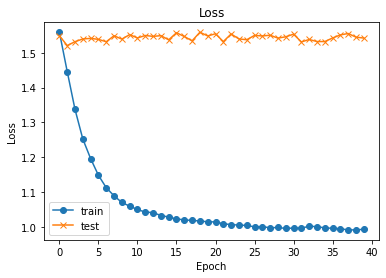

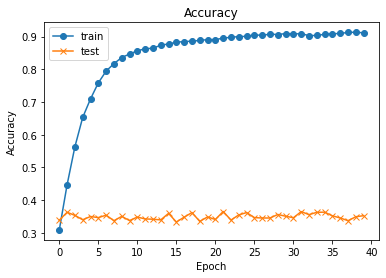

In [186]:
plot_metric([train_losses, test_losses], ['train', 'test'], 'Epoch', 'Loss', 'Loss')
print('\n')
plot_metric([train_accuracies, test_accuracies], ['train', 'test'], 'Epoch', 'Accuracy', 'Accuracy')

## Finding misclassified texts

In [197]:
categories = {0: "Big Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Big Positive"}

j = 0
for batch in test_iterator:
    # pred = classify_tweet('I am very negative negative negaive')

    pred_label = batch.labels
    pred_texts, pred_text_lengths = batch.texts
    pred_text, pred_text_length = pred_texts[0], pred_text_lengths[0]
    # print(pred_text, pred_text_length)

    # Get the model prediction                  
    prediction = model(pred_text.unsqueeze(0), pred_text_length.unsqueeze(0))
    _, pred = torch.max(prediction, 1) 

    print('Sentence : ', ' '.join([text.vocab.itos[x] for x in list(pred_text)]))
    print('\tPredicted Label : ', categories[pred.item()])
    print('\tCorrect Label   : ', categories[pred_label[0].item()])
    
    if j > 12:
        break

Sentence :  <unk> motions for <unk> .
	Predicted Label :  Negative
	Correct Label   :  Neutral
Sentence :  Something like <unk> the toilet .
	Predicted Label :  Neutral
	Correct Label   :  Negative
Sentence :  Morton is , as usual , brilliant .
	Predicted Label :  Positive
	Correct Label   :  Positive
Sentence :  A painfully funny ode to bad behavior .
	Predicted Label :  Negative
	Correct Label   :  Big Negative
Sentence :  A poignant , artfully crafted meditation on mortality .
	Predicted Label :  Positive
	Correct Label   :  Positive
Sentence :  <unk> substitutes atmosphere for action , tedium for thrills .
	Predicted Label :  Big Positive
	Correct Label   :  Negative
Sentence :  But this time there 's some mold on the gold .
	Predicted Label :  Negative
	Correct Label   :  Negative
Sentence :  A deviant topical comedy which is funny from start to finish .
	Predicted Label :  Negative
	Correct Label   :  Positive
Sentence :  <unk> dramas fused with love triangle is a well worn conce

In [37]:
# #load weights and tokenizer

# path='/content/END2/weights/best_model.pt'
# model.load_state_dict(torch.load(path));
# model.eval();
# tokenizer_file = open('/content/END2/S5/tokenizer.pkl', 'rb')
# tokenizer = pickle.load(tokenizer_file)

# #inference

# import spacy
# nlp = spacy.load('en')

# def classify_tweet(text):
#     categories = {0: "Big Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Big Positive"}
    
#     tokenized = [tok.text for tok in nlp.tokenizer(text)] 

#     # convert to integer sequence using predefined tokenizer dictionary
#     indexed = [tokenizer[t] for t in tokenized]               
#     length = [len(indexed)]

#     # convert sentence to tensor                                    
#     tensor = torch.LongTensor(indexed).to(device)
#     # reshape in form of batch, no. of words           
#     tensor = tensor.unsqueeze(1).T
 
#     # convert length to tensor                          
#     length_tensor = torch.LongTensor(length)

#     # Get the model prediction                  
#     prediction = model(tensor, length_tensor)

#     _, pred = torch.max(prediction, 1) 
    
#     return categories[pred.item()]

# ----

-------
-------

# Data Augmentations - Doing Random Swap and Random Delete

In [ ]:
! pip install nlpaug

In [101]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [102]:
random_swap = naw.RandomWordAug(action="swap", aug_p=20, aug_min=2, aug_max=10)
random_delete = naw.RandomWordAug(action="delete", aug_p=20, aug_min=2, aug_max=10)

In [105]:
df_sample1 = df_train.sample(int(df_train.shape[0]/4))
df_sample2 = df_train.sample(int(df_train.shape[0]/4))

In [106]:
print(df_sample1.shape), print(df_sample2.shape)

(2371, 2)
(2371, 2)


(None, None)

In [111]:
aug_data_swap = {'label': [], 'text': []}
aug_data_delete = {'label': [], 'text': []}

for ix, (label_field, text_field) in df_sample1.iterrows():
    aug_data_swap['text'].append(random_swap.augment(text_field))
    aug_data_swap['label'].append(label_field)

for ix, (label_field, text_field) in df_sample2.iterrows():
    # print(text_field)
    # print(label_field)
    aug_data_delete['text'].append(random_delete.augment(text_field))
    aug_data_delete['label'].append(label_field)

In [112]:
assert len(aug_data_swap['label']) == len(aug_data_swap['text']), "Some error occured. Size Mismatch!"
print(len(aug_data_swap['text']))

assert len(aug_data_delete['label']) == len(aug_data_delete['text']), "Some error occured. Size Mismatch!"
len(aug_data_delete['text'])

2371


2371

In [121]:
df_swap = pd.DataFrame.from_dict(aug_data_swap)
df_swap.to_csv("random_swap_25percent.csv", index=False)
df_swap.head()

,label,text
0,1,Is story the and its - bogus characters thin t...
1,4,It never it makes quite the to boiling point b...
2,2,() Newton through wanders CHARLIE completely n...
3,5,' it s the kind effectively of creepy - scary ...
4,4,"Diaz, Applegate, and Blair Posey suitably are ..."


In [122]:
df_delete = pd.DataFrame.from_dict(aug_data_delete)
df_delete.to_csv("random_delete_25percent.csv", index=False)
df_delete.head()

,label,text
0,2,Its thorn (and simple humanity) plundered by s...
1,4,( Scherfig) made will you wondering about the ...
2,2,Diane Lane ' performance n ' t Adrian ' from.
3,4,"Terry is sort of geriatric, which will Eastwoo..."
4,3,"Empty, - and - street credibility."


# Using Back-Translation - Google Trans

In [ ]:
!pip install googletrans==3.1.0a0

In [83]:
import random
import googletrans
translator = googletrans.Translator()

# Selecting random sample - Picking 5% of the training data - API has limits
df_sample1 = df_train.sample(int(df_train.shape[0]*0.05))

In [86]:
aug_data_translate = {'label': [], 'text': []}
for ix, (label_field, text_field) in df_sample1.iterrows():
    sentence = [text_field]

    available_langs = list(googletrans.LANGUAGES.keys()) 
    trans_lang = random.choice(available_langs) 
    print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

    translations = translator.translate(sentence, dest=trans_lang)
    t_text = [t.text for t in translations]
    print(t_text)

    translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
    en_text = [t.text for t in translations_en_random]
    print(en_text)

    aug_data_translate['label'].append(label_field)
    aug_data_translate['text'].append(en_text)

["It 's consistently funny , in an irresistible junior-high way , and consistently free of any gag that would force you to give it a millisecond of thought ."]
Translating to dutch
['Het is altijd grappig, op een onweerstaanbare middelbare school en consequent vrij van elke grap die je zou dwingen er een milliseconde over na te denken.']
["It's always funny, in an irresistible high school, and consistently free of any joke that would force you to think about it for a millisecond."]
['A muddy psychological thriller rife with miscalculations .']
Translating to mongolian
['Буруу тооцоотой, шаварлаг сэтгэлзүйн триллер.']
['Miscalculated, muddy psychological thriller.']
['LaBute masterfully balances both Traditional or Modern stories together in a manner that one never overwhelms the other .']
Translating to javanese
['LaBute bisa ngimbangi crita-crita Tradhisional utawa Modern kanthi trampil kanthi cara sing ora nate ngalahake liyane.']
['LaBute is able to balance Traditional or Modern sto

In [89]:
assert len(aug_data_translate['label']) == len(aug_data_translate['text']), "Some error occured. Size Mismatch!"
len(aug_data_translate['text'])

474

In [95]:
df_translate = pd.DataFrame.from_dict(aug_data_translate)
df_translate['text'] = df_translate['text'].apply(lambda x: x[0] )
df_translate.head()

,label,text
0,4,"It's always funny, in an irresistible high sch..."
1,2,"Miscalculated, muddy psychological thriller."
2,5,LaBute is able to balance Traditional or Moder...
3,1,"For a depressing story, this is a heart-wrench..."
4,3,"Few of the increasingly attracted events, foll..."


In [100]:
df_translate.to_csv("back_translate_5percent.csv", index=False)